(6838, 13)


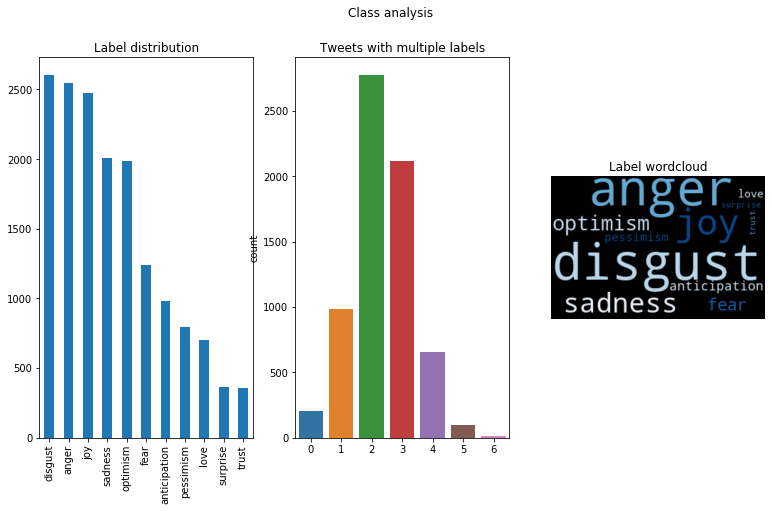

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Giorgos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


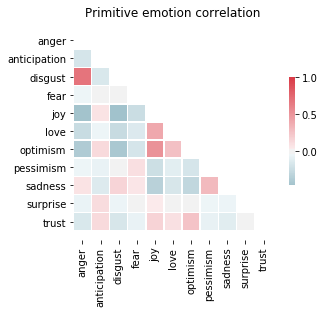

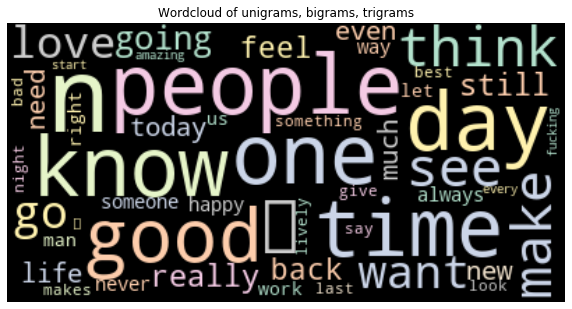

C:\Users\Giorgos\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


((5470, 5329), (5470, 11), (1368, 5329), (1368, 11))

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from datetime import datetime
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

from TweetProcessor import TweetProcessor as tp
tweet_processor = tp.TweetProcessor()
start_all = datetime.now()

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(y_test, y_pred):
   accuracy = np.around(metrics.accuracy_score(y_test, y_pred),3)
   precision = np.around(metrics.precision_score(y_test, y_pred, average='macro'),3)
   recall = np.around(metrics.recall_score(y_test, y_pred, average='macro'),3)
   f1_score = np.around(metrics.f1_score(y_test, y_pred, average='macro'),3)
   print(classification_report(y_test, y_pred))  
   print('accuracy: %s' % accuracy)
   print('precision: %s' % precision)
   print('recall: %s' % recall)
   print('f1_score: %s' % f1_score)
   return {'accuracy':accuracy, 
           'precision':precision, 
           'recall':recall,
           'f1_score':f1_score}

def vader_sentiment(doc):
   analyzer= SentimentIntensityAnalyzer()
   score = analyzer.polarity_scores(doc)['compound']
   if score == 0:
      return 'neutral'
   elif score < 0:
      return 'negative'
   else:
      return 'positive'
   
def textblob_sentiment(doc):
   from textblob import TextBlob
   score = TextBlob(doc).sentiment.polarity
   if score == 0:
      return 'neutral'
   elif score < 0:
      return 'negative'
   else:
      return 'positive'
   
def plot_confusion_matrix(y_test, y_pred):
   from sklearn.preprocessing import MinMaxScaler
   from sklearn.metrics import classification_report, confusion_matrix
   
   labels = np.unique(y_test)
   cm = confusion_matrix(y_test, y_pred, labels=labels)
   cm_df = pd.DataFrame(cm, index=labels, columns=labels)
   print(cm_df)
   cmap = sns.color_palette("OrRd", 1000)
   ax = sns.heatmap(cm_df, cmap=cmap, annot=True, fmt='g')
   bottom, top = ax.get_ylim()
   ax.set_ylim(bottom + 0.5, top - 0.5)
   
def vizualize_classification(y_test, y_pred):
   from sklearn.metrics import classification_report, confusion_matrix
   labels = np.unique(y_test)
   cmap = sns.color_palette("OrRd", 1000)
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,7))
   fig.suptitle('Vizualizing classifier')
   
   ax = sns.countplot(x=y_pred, hue=y_test, order=labels, ax=ax1)
   
   cm = confusion_matrix(y_test, y_pred, labels=labels)
   cm_df = pd.DataFrame(cm, index=labels, columns=labels)
   print('Confusion Matrix: \n', cm_df)
   ax = sns.heatmap(cm_df, cmap=cmap, annot=True, fmt='g', ax=ax2)
   bottom, top = ax.get_ylim()
   ax.set_ylim(bottom + 0.5, top - 0.5)
   evaluate_model(y_test, y_pred)
      
def textblob_NBClassifier(doc):
   blob = TextBlob(doc, classifier=cl)
   return blob.classify()

def multilabel_evaluation(y_pred, y_test, measurement=None):
   '''
   Micro accuracy, recall, precision, f1_score evaluation
   '''
   from sklearn.metrics import hamming_loss, multilabel_confusion_matrix
   multilabel_cm = multilabel_confusion_matrix(y_pred, y_test)
   if measurement=='macro':
      tn = np.mean(multilabel_cm[:, 0, 0])
      tp = np.mean(multilabel_cm[:, 1, 1])
      fp = np.mean(multilabel_cm[:, 0, 1])
      fn = np.mean(multilabel_cm[:, 1, 0])
      accuracy = np.around(((tp + tn)/(tn + tp + fn +fp)), 3)
      precision = np.around((tp/(tp + fp)), 3)
      recall = np.around((tp/(tp + fn)), 3)
      f1_score = np.around(2* recall*precision/(recall + precision), 3)
   else:
      tn = multilabel_cm[:, 0, 0]
      tp = multilabel_cm[:, 1, 1]
      fp = multilabel_cm[:, 0, 1]
      fn = multilabel_cm[:, 1, 0]
      ac, p, r = [], [], []
      for i in range(len(tp)):
         ac.append((tp[i] + tn[i])/(tn[i] + tp[i] + fn[i] + fp[i]))
         p.append(0 if tp[i]==0 and fp[i]==0 else tp[i]/(tp[i] + fp[i]))
         r.append(0 if tp[i]==0 and fn[i]==0 else tp[i]/(tp[i] + fn[i]))
     
      accuracy = np.around(np.mean(ac), 3)
      precision = np.around(np.mean(p), 3)
      recall = np.around(np.mean(r), 3)   
      f1_score = np.around(2* recall*precision/(recall + precision), 3)
   hamming = np.around(hamming_loss(y_test, y_pred), 3)
   return {'accuracy':accuracy, 
           'precision':precision, 
           'recall':recall,
           'f1_score':f1_score,
           'hamming_loss':hamming}

def multilabel_visualization(values, labels):
   df = pd.DataFrame(data={label:values[:,i] for i, label in enumerate(feelings)})
   fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,7))
   fig.suptitle('Class analysis')
   # Label distribution
   df[labels].sum().sort_values(ascending=False).plot(kind='bar', title='Label distribution', ax=ax1)
   # Multiple labels
   sns.countplot(x=df[labels].sum(axis=1), ax=ax2).set_title('Tweets with multiple labels')
   # Word cloud
   # Create target column 'labels'
   df['labels'] = [np.asarray(labels)[i] for i in df[labels].astype('bool').values]
   # Concatenate all labesl together
   words = np.hstack(df['labels'].values)
   # Vizualize label wordcloud
   wc_dict = dict(Counter(words))
   wordcloud = WordCloud(colormap='Blues', 
                         max_font_size=100, 
                         width=300, 
                         height=200).generate_from_frequencies(wc_dict)
   plt.title('Label wordcloud')
   # plt.figure( figsize=(20,10) )

   plt.imshow(wordcloud, interpolation='bilinear')
   plt.axis("off")
   plt.show()
   # correlation visualization
   emotion_corr_heatmap(values, labels=labels)
   
def emotion_corr_heatmap(values, labels=[]):
   if type(values)==pd.DataFrame:
      data = values.corr()
   else:
      data = pd.DataFrame(data=values, columns=labels).corr()
   
   # Generate a mask for the upper triangle
   mask = np.triu(np.ones_like(data, dtype=np.bool))
   cmap = sns.diverging_palette(220, 10, as_cmap=True)
   # Draw the heatmap with the mask and correct aspect ratio
   max_val = np.sort(data, axis=None)[::-1][data.shape[1]]
   ax = sns.heatmap(data, 
               mask=mask, 
               cmap=cmap, 
               center=0,
               square=True, 
               linewidths=.5, 
               cbar_kws={"shrink": .5})
   plt.title('Primitive emotion correlation')
   bottom, top = ax.get_ylim()
   ax.set_ylim(bottom + 0.5, top - 0.5)
   
def draw_wordcloud(corpus):
   from wordcloud import WordCloud, STOPWORDS
   from collections import Counter
   from nltk.util import ngrams 
   from nltk.corpus import stopwords
   
   if type(corpus)!=str:
      corpus = ' '.join(corpus).split(' ')
   stop_words = set(list(STOPWORDS) + stopwords.words('english'))
   corpus = [w for w in corpus if w.lower() not in stop_words]
   bigrams_count = {' '.join(ngram):count for ngram,count in Counter(ngrams(corpus, 2)).most_common()}
   trigrams_count = {' '.join(ngram):count for ngram,count in Counter(ngrams(corpus, 3)).most_common()}   
   corpus_dict = dict(Counter(corpus).most_common())
   word_count = {**corpus_dict, **bigrams_count, **trigrams_count}
   # draw a Word Cloud with word frequencies
   wordcloud = WordCloud(max_words=50,
                         max_font_size=75,
                         colormap='Pastel2_r',
                        ).generate_from_frequencies(word_count)
   plt.figure(figsize=(10,8))
   plt.title('Wordcloud of unigrams, bigrams, trigrams')
   plt.imshow(wordcloud, interpolation='bilinear')
   plt.axis("off")
   plt.show()
 
    
emo_train_df = pd.read_csv('data/2018-E-c-En-train.txt', sep='\t')
emo_test_df = pd.read_csv('data/2018-E-c-En-test-gold.txt', sep='\t')
print(emo_train_df.shape)
emo_train_df.head()


feelings = emo_train_df.columns[2:]#['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
multilabel_visualization(emo_train_df[feelings].values, feelings)


import nltk
nltk.download('stopwords')

emo_train_df['tokenized_features'] = emo_train_df['Tweet'].apply(tweet_processor.tweet_pipeline)

corpus = emo_train_df['tokenized_features'].apply(lambda x: ' '.join(x))
draw_wordcloud(corpus)


# Tweet preprocessing
emo_train_df['tokenized_features'] = emo_train_df['Tweet'].apply(tweet_processor.tweet_pipeline)
X = emo_train_df['tokenized_features'].apply(lambda x: ' '.join(x)).values

# TF-IDF text features
vectorizer = tweet_processor.tfidf_vectorizer(X)
X_tfidf = vectorizer.transform(X)

# TF-IDF emoji features
vectorizer = tweet_processor.emoji_vectorizer(X)
X_emoji = vectorizer.transform(X)

# LDA features
X_lda = tweet_processor.lda_features(X, len(feelings))


# Combine features
X_combined = np.hstack((X_tfidf.toarray(), X_emoji.toarray()))
y = emo_train_df[feelings].values
x_train_id, x_test_id, y_train, y_test = train_test_split(range(X_combined.shape[0]), y, test_size=0.2, random_state=0)
x_train, x_test = X_combined[x_train_id], X_combined[x_test_id]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
from torch.utils import data
from sklearn.metrics import accuracy_score
import torch.optim as optim

class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(in_features=5329, out_features=1000,bias=False)
        self.encoder_hidden_layer2 = nn.Linear(in_features=1000, out_features=500,bias=False)
        
        self.encoder_output_layer = nn.Linear(in_features=500, out_features=100,bias=False)
        
        self.decoder_hidden_layer2 = nn.Linear(in_features=100, out_features=500,bias=False)
        self.decoder_hidden_layer = nn.Linear(in_features=500, out_features=1000,bias=False)
        
        self.decoder_output_layer = nn.Linear(in_features=1000, out_features=5329,bias=False)
        

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        
        activation = self.encoder_hidden_layer2(activation)
        activation = torch.relu(activation)
        
        code = self.encoder_output_layer(activation)
        
        activation = self.decoder_hidden_layer2(code)
        activation = torch.relu(activation)
        
        activation = self.decoder_hidden_layer(activation)
        activation = torch.relu(activation)
        reconstructed = self.decoder_output_layer(activation)
        
        
        return reconstructed
    
    def encode(self,features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        activation = self.encoder_hidden_layer2(activation)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        return code
        

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data)
        self.target = torch.from_numpy(target)
        
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

    


dataset = MyDataset(x_train, x_train)
test_dataset = MyDataset(x_test, x_test)

loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)



# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# mean-squared error loss
criterion = nn.MSELoss(size_average= False)

model = AE()
model.load_state_dict(torch.load("encoder",map_location='cuda'))
model.eval()
model.double()
model.to(device)
train_set = []
test_set = []

with torch.set_grad_enabled(False):
    for batch_idx, (data, target) in enumerate(loader):
        # Transfer to GPU
        data, target = data.to(device), target.to(device)
            
        # compute reconstructions
        outputs = model.encode(data)
        outputs = torch.cat((outputs, data), 1)
        train_set.extend(outputs)
        
with torch.set_grad_enabled(False):
    for batch_idx, (data, target) in enumerate(test_loader):
        # Transfer to GPU
        data, target = data.to(device), target.to(device)
            
        # compute reconstructions
        outputs = model.encode(data)
        outputs = torch.cat((outputs, data), 1)
           
        test_set.extend(outputs)

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)




def class_wrong (y_test, pred_array ):
    a = numpy.zeros(11)
    i=0
    for pred in pred_array:
        j=0
        for pr in pred:
            
            if pr ==1 and y_test[i][j].item()==1:
                a[j]= a[j]+1
                
            j=j+1
            
            
        i= i+1
        
        
    return a


def class_count (y_test):
    i=0
    a = numpy.zeros(11)
    for pred in y_test:
        j=0
        for pr in pred:
            
            if pr.item() == 1:
                a[j]= a[j]+1
                
            j=j+1
            
            
        i= i+1
    
    return a


def ret_percentage(right,all_data):
    arr = []
    for (r,d) in zip(right,all_data):
        
        perc = str('{0:.2g}'.format(r/d)) + "%"
        arr.append(perc)
    
    return arr
    


c = class_count(y_train)
sm = numpy.sum(c)
new_c = []

for num in c:
    k = sm/num
    new_c.append(k)


sm = numpy.array(new_c)
mn = numpy.amin(sm)

new_c = []
for num in sm:
    k = (num)/mn
    new_c.append(k)
    
sm = numpy.array(new_c)
pw = torch.from_numpy(sm)


def save_to_txt(name,acc_all,ep,best_perc,feelings):
    file1 = open(name+".txt","a") 
    a = str("Epoch is:"+ str(ep)+"\n")
    file1.write(a)
    a = str(str(acc_all) +"\n")
    file1.write(a)
    for (perc,feel) in zip(best_perc,feelings):
            a = str(feel +" "+ perc +"\n")
            file1.write(a)
    file1.close() 

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5429, 100)  
        self.fc2 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 11)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc4(x)
        
        return x

    
max_epochs = 50
model = Net()
model.to(device)
model.double()
m = nn.Sigmoid()



pos_weight = pw
pos_weight.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight.double()).to(device)

b = class_count(y_test)
best_test_acc = 0
t=0
train_loss_all=0
for epoch in range(max_epochs):
    
    # Training
    loss=0
    t_loss=0
    i=0
    for i in range(len(train_set)):
        data = train_set[i]
        target= y_train[i]
        
        
        
        data, target = data.to(device), target.to(device)
        # compute reconstructions
        outputs = model(data)
        outputs = outputs.to(device)
        train_loss = criterion(outputs, target.double())
        # compute training reconstruction loss
        train_loss_all = train_loss + train_loss_all
        
        if t%64==0:
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
            train_loss_all.backward()
            optimizer.step()
            train_loss_all=0
            
        
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()/len(data)
        t=t+1
    
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.12f}".format(epoch + 1, max_epochs, loss))

    # Validation
    i=0
    pred_array = []
    with torch.set_grad_enabled(False):
        for i in range(len(test_set)):
            # Transfer to GPU
            
            data = test_set[i]
            target= y_test[i]
            data, target = data.to(device), target.to(device)
            
            # compute reconstructions
            outputs = model(data)
            
            #outputs = m(outputs)
            pred = []
            
            outputs = m(outputs)
            j=0
            for out in outputs:
                
                if out.item()>0.95:
                    pred.append(1)
                else:
                    pred.append(0)
                j=j+1
            
            pred = numpy.array(pred)
            pred_array.append(pred)

            test_loss = criterion(outputs, target.double())
            
            # add the mini-batch test loss to epoch loss
            t_loss += test_loss.item()/len(data)
            
        a = class_wrong(y_test, pred_array)
        pred_array = numpy.array(pred_array)
        acc_score = multilabel_evaluation(y_test, pred_array)  
        
            
        print("epoch : {}/{},test loss = {:.12f}".format(epoch + 1, max_epochs, t_loss))
        print("Accuracy is:",acc_score)
        for (perc,feel) in zip(ret_percentage(a,b),feelings):
    
            print (feel , perc)  
        
        if  acc_score["accuracy"]> best_test_acc:
            best_test_acc=acc_score["accuracy"]
            acc_all = acc_score
            ep=epoch+1
            best_perc=ret_percentage(a,b)
            torch.save(model.state_dict(), "cost_sensitive_Encoder")
        print("")
        
        
name =   "cost_sensitive_Encoder"    
save_to_txt(name,acc_all,ep,best_perc,feelings)